In [3]:
import pandas as pd
from dtaidistance import dtw
from dtaidistance import dtw_ndim
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [4]:
df = pd.read_csv('toy_vitals.csv',index_col=0)

In [5]:
df

,sys_pressure,dia_pressure,temp
patinet1_1,100,70,38
patinet1_2,120,80,39
patinet1_3,140,50,39
patinet2_1,140,50,40
patinet2_2,150,60,38
patinet2_3,130,50,38
patient3_1,100,40,39
patient3_2,90,70,38
patient3_3,100,80,36
patient4_1,110,50,38


In [6]:
df['rid'] = [i.split('_')[0].split('t')[2] for i in df.index.tolist()]

In [7]:
# reshape
temp_traj = df.groupby('rid').temp.apply(np.hstack).reset_index()
dia_traj = df.groupby('rid').dia_pressure.apply(np.hstack).reset_index()
sys_traj = df.groupby('rid').sys_pressure.apply(np.hstack).reset_index()

In [8]:
# reshape
tmp = pd.merge(temp_traj, dia_traj, on ='rid')
traj = pd.merge(tmp, sys_traj, on = 'rid')

In [9]:
# reshape
traj_arr = np.array(traj.drop('rid',axis = 1))
traj_arr

array([[array([38, 39, 39]), array([70, 80, 50]), array([100, 120, 140])],
       [array([40, 38, 38]), array([50, 60, 50]), array([140, 150, 130])],
       [array([39, 38, 36]), array([40, 70, 80]), array([100,  90, 100])],
       [array([38, 38, 36]), array([50, 80, 80]), array([110, 100, 100])]],
      dtype=object)

In [10]:
traj_arr.shape

(4, 3)

In [197]:
## doesn't work with data of different dimensions
dtw_ndim.distance(traj_arr[1], [[40, 38], [50, 60], [140, 150]])

ValueError: operands could not be broadcast together with shapes (3,) (2,) 

In [12]:
# calc distance for first patient
print(dtw_ndim.distance(traj_arr[0], traj_arr[1]), dtw_ndim.distance(traj_arr[1], traj_arr[2]), dtw_ndim.distance(traj_arr[2], traj_arr[3]))

58.360945845659494 84.88227141164403 20.024984394500787


In [13]:
mt = np.zeros((traj_arr.shape[0],traj_arr.shape[0]))

In [14]:
# function for dtw matrix
for i in range(traj_arr.shape[0]):
    j = i + 1
    #print('init: ', i,j)
    while j < traj_arr.shape[0]:
        dtw = dtw_ndim.distance(traj_arr[i], traj_arr[j])
        mt[i,j] = dtw
        mt[j,i] = dtw
        j+= 1
        #print('loop', i,j)

In [15]:
mt

array([[ 0.        , 58.36094585, 66.41535967, 58.39520528],
       [58.36094585,  0.        , 84.88227141, 74.88658091],
       [66.41535967, 84.88227141,  0.        , 20.02498439],
       [58.39520528, 74.88658091, 20.02498439,  0.        ]])

<ipython-input-16-70d468311d82>:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = shc.linkage(mt,


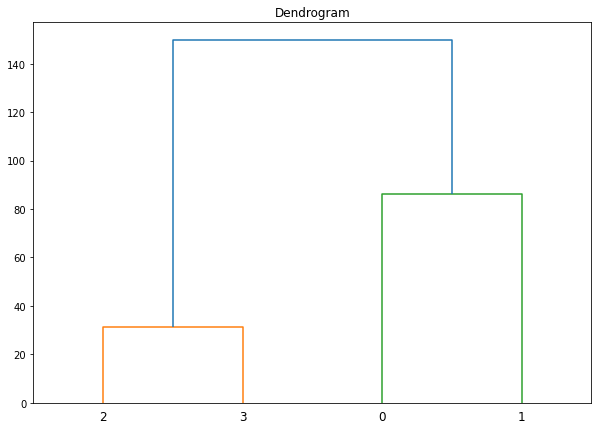

In [16]:
# hac
plt.figure(figsize=(10, 7))
plt.title("Dendrogram")
clusters = shc.linkage(mt, 
            method='ward', 
            metric="euclidean")
shc.dendrogram(Z=clusters)
plt.show()